In [37]:
library(rjags)
library(runjags)
library(R2jags)

In [38]:
tot_vaccine <- 18198
tot_placebo <- 18325
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 8
pos_placebo <- 162
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
pfizer.tb <- tibble::tibble(tested = tested, patient=patient)
table(pfizer.tb[[2]], pfizer.tb[[1]])

         
            Neg   Pos
  Placebo 18163   162
  Vaccine 18190     8

In [39]:
dataList = list(
    tested = ifelse(pfizer.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(pfizer.tb$patient)),
    Ntot = nrow(pfizer.tb) ,
    Nclass = nlevels(factor(pfizer.tb$patient))
)

In [40]:
modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Pfizer_model.txt")

In [41]:
pfizer_chains <- run.jags(modelString ,
                          sample = 15000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jun 23 15:40:25 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 36523
   Unobserved stochastic nodes: 2
   Total graph size: 73055
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

In [42]:
summary(pfizer_chains)

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],7.62419e-03,0.008934260,0.01033510,8.958023e-03,0.0006933547,NA,3.452438e-06,0.5,40333,-0.0021424430,1.0000014
theta[2],2.71893e-04,0.000582704,0.00096441,6.015967e-04,0.0001815712,NA,9.156425e-07,0.5,39323,-0.0019894573,0.9999847
theta[3],8.89988e+01,93.475550000,96.99350000,9.324410e+01,2.1116049814,NA,1.054845e-02,0.5,40073,-0.0004447462,1.0000151


In [54]:
add.summary(pfizer_chains)

Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 60000 samples (chains = 4; adapt+burnin = 5000):
                                                                              
            Lower95    Median    Upper95       Mean         SD Mode      MCerr
theta[1]  0.0076099 0.0089358   0.010329  0.0089564  0.0006943   -- 2.8385e-06
theta[2] 0.00027165 0.0005832 0.00096354 0.00060176 0.00018155   -- 7.4835e-07
theta[3]      89.01    93.476     97.001     93.241     2.1113   --  0.0084708
                                         
         MC%ofSD SSeff       AC.10   psrf
theta[1]     0.4 59830  -0.0021424 1.0001
theta[2]     0.4 58855  -0.0019895      1
theta[3]     0.4 62121 -0.00044475      1

Total time taken: 1.5 minutes


In [45]:
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

In [46]:
pfizer_res    <- tidybayes::tidy_draws(pfizer_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

In [47]:
pfizer.mcmc <- as.mcmc(pfizer_res)
pfizer.data <- as.data.frame(pfizer.mcmc)

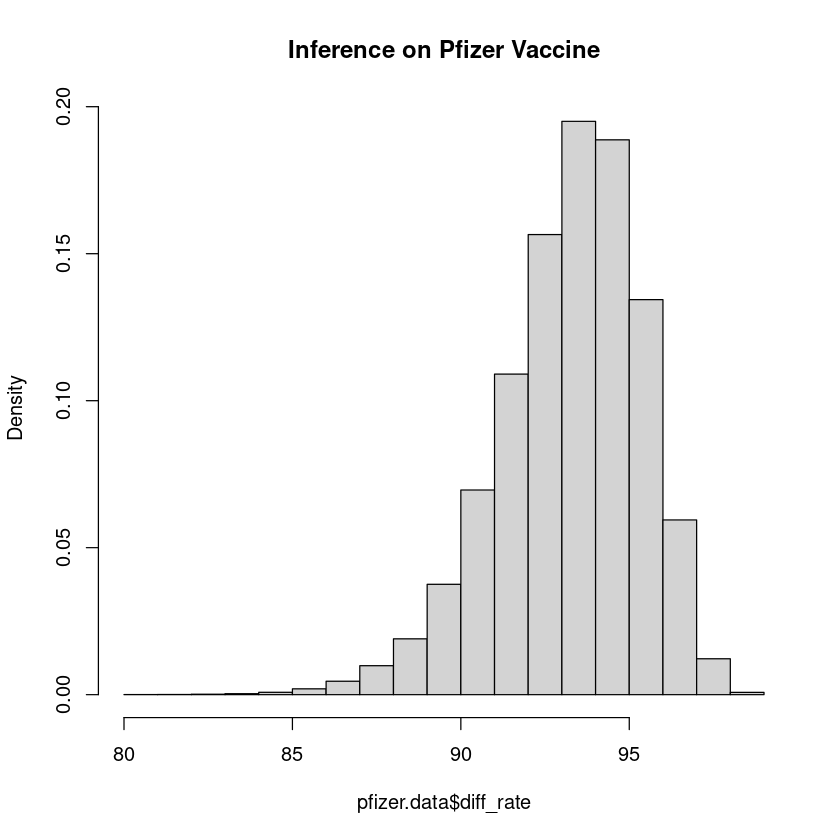

In [48]:
hist(pfizer.data$diff_rate,freq=FALSE,main='Inference on Pfizer Vaccine')

In [49]:
bayestestR::describe_posterior(pfizer.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,93.91715,0.95,89.00957,97.00063,1


In [55]:
all.mcmc <- as.mcmc.list(pfizer_chains)

Placebo      Vaccine    diff_rate Placebo_perc Vaccine_perc 
    60505.52     59300.55     60000.00     60505.52     59300.55

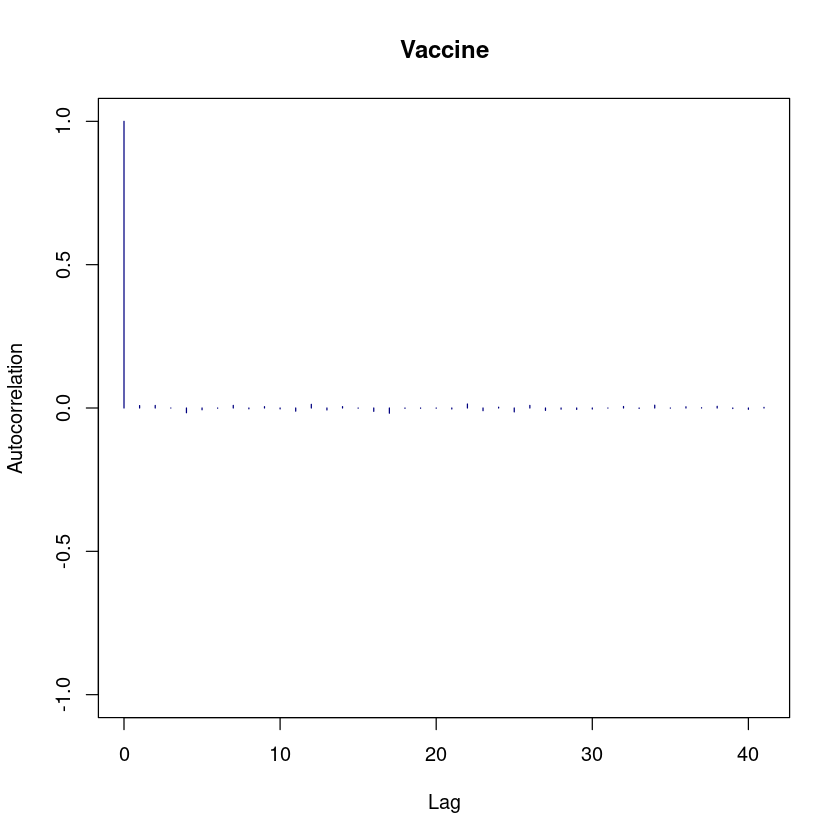

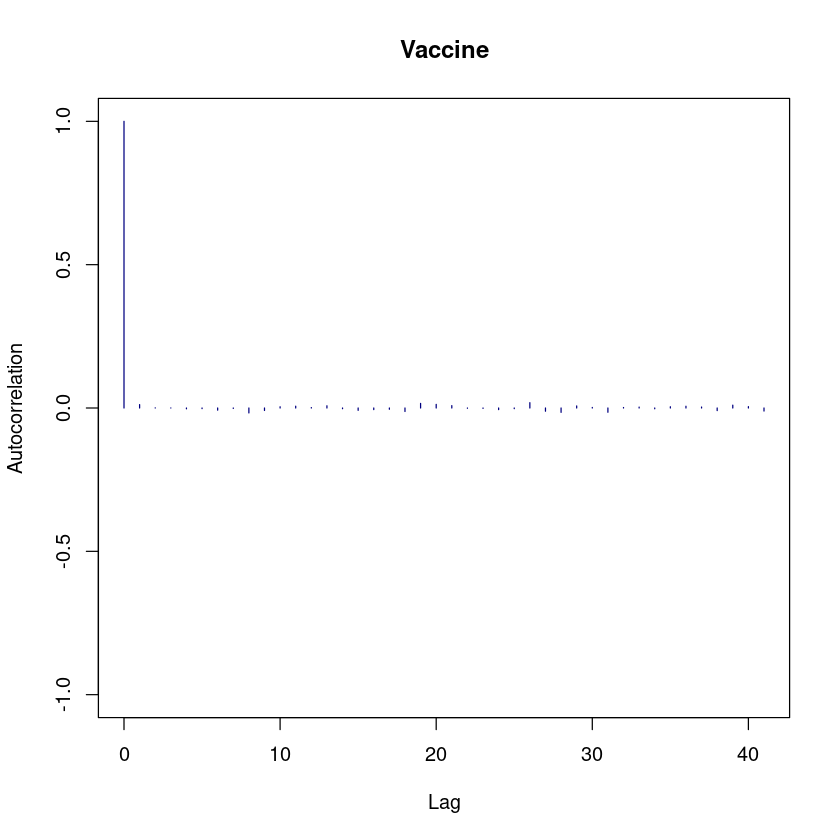

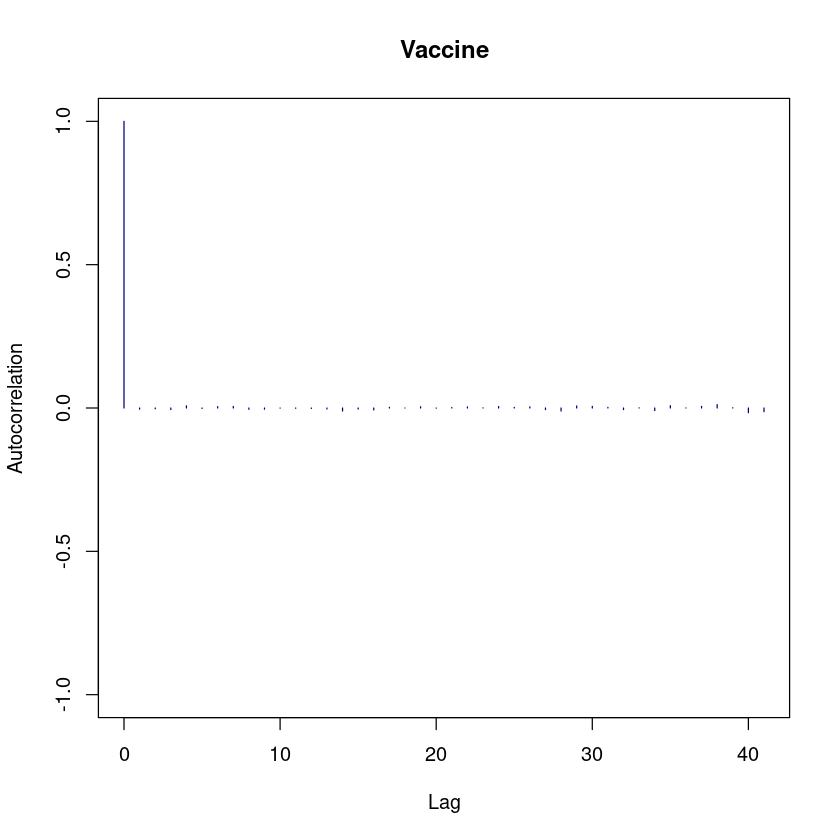

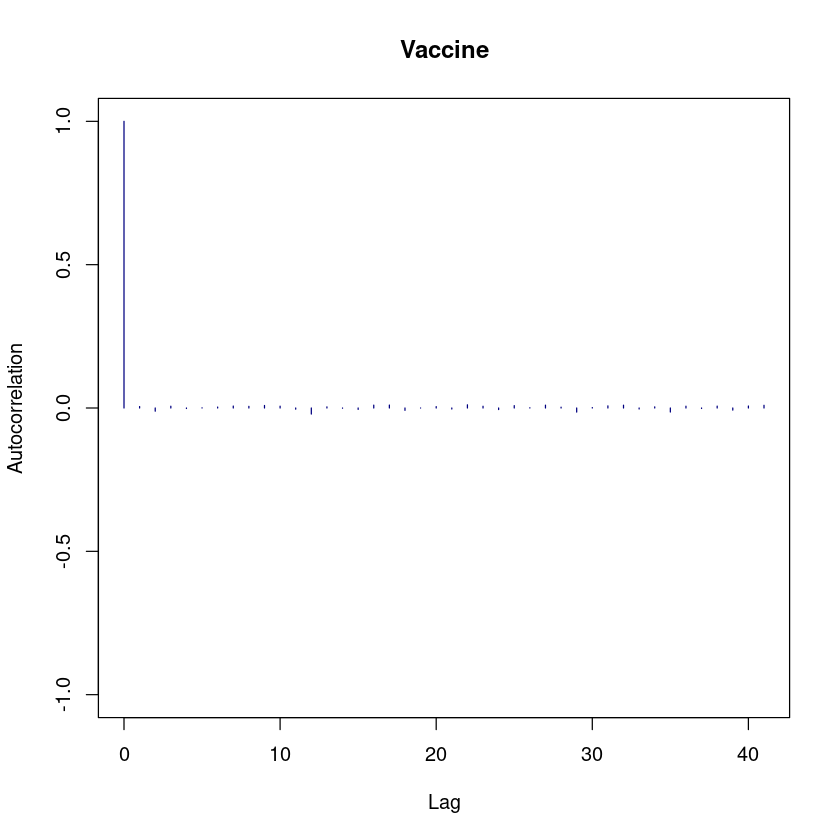

In [34]:
effectiveSize(pfizer.mcmc)
#autocorr.plot(pfizer.mcmc[,'Vaccine'],main='Vaccine')
autocorr.plot(all.mcmc[,'theta[3]'],col='navy',main='Vaccine',new=TRUE)

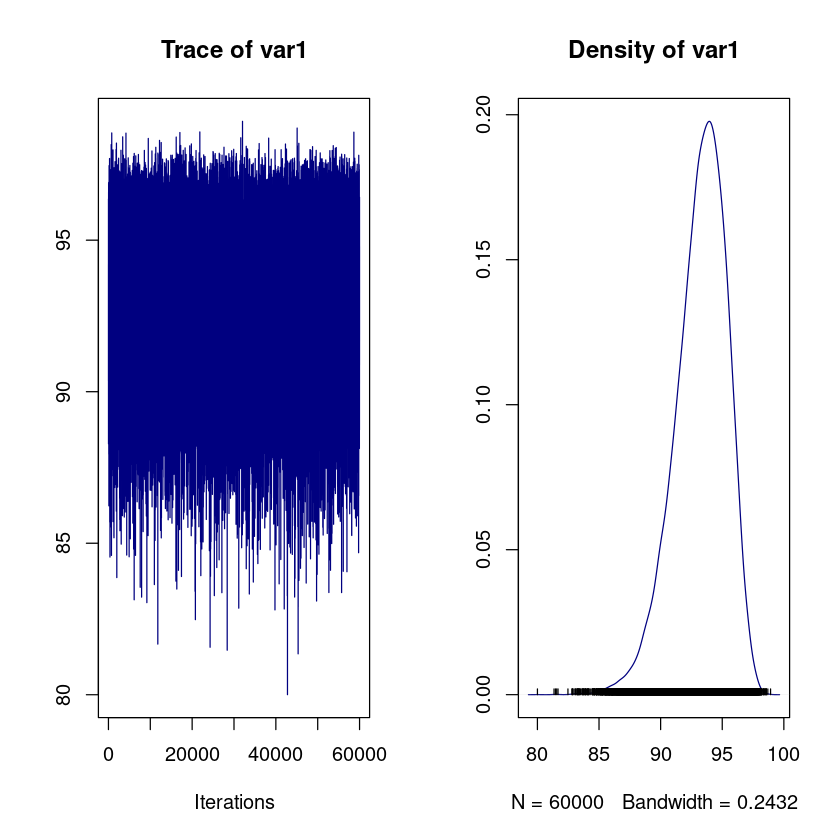

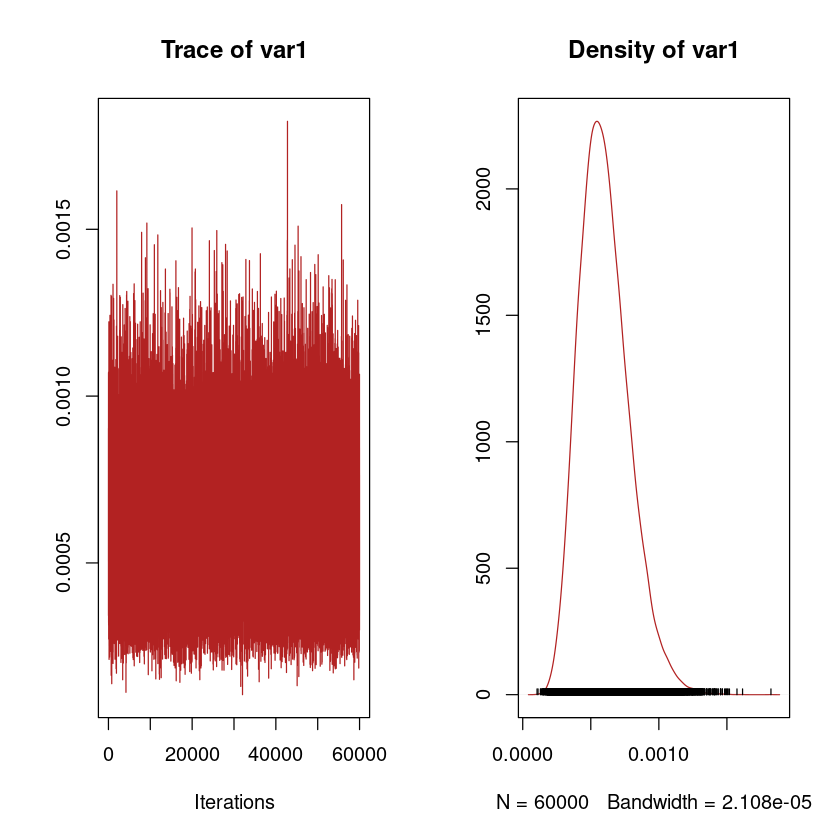

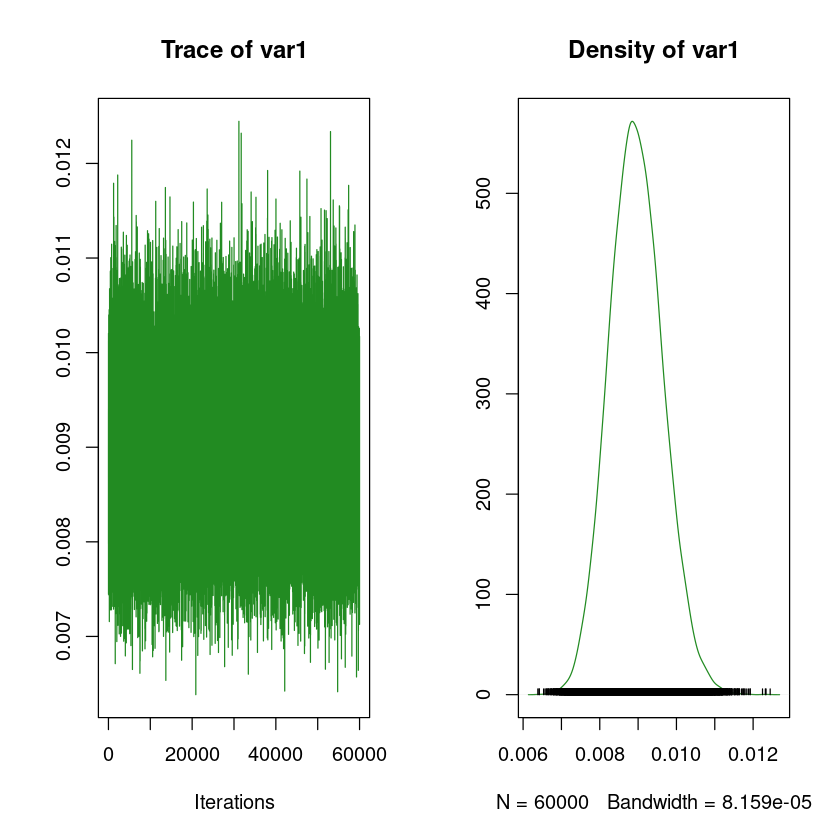

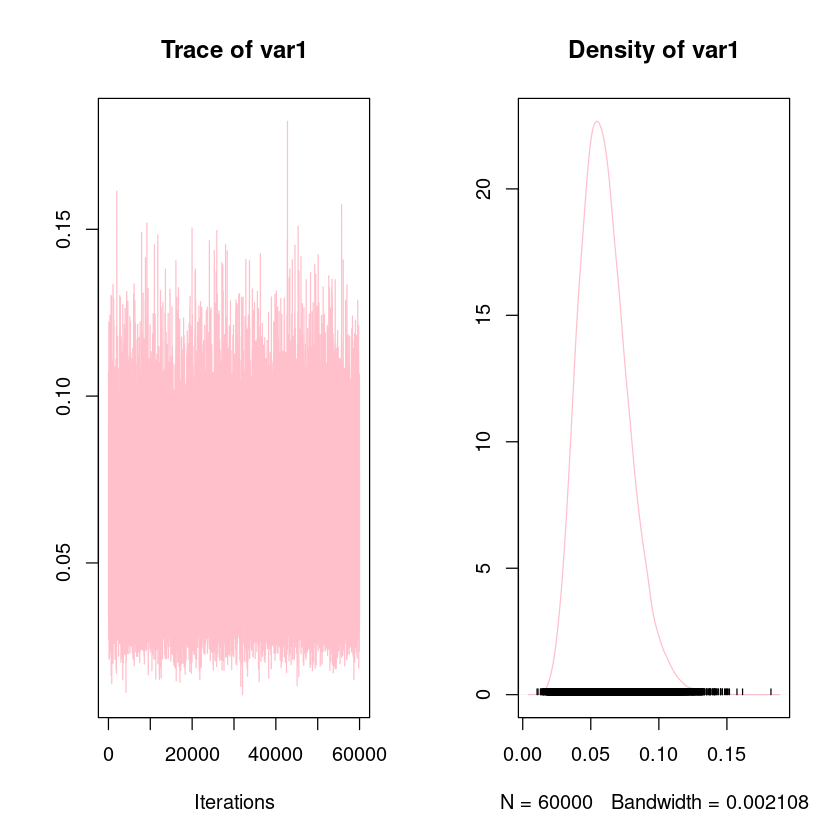

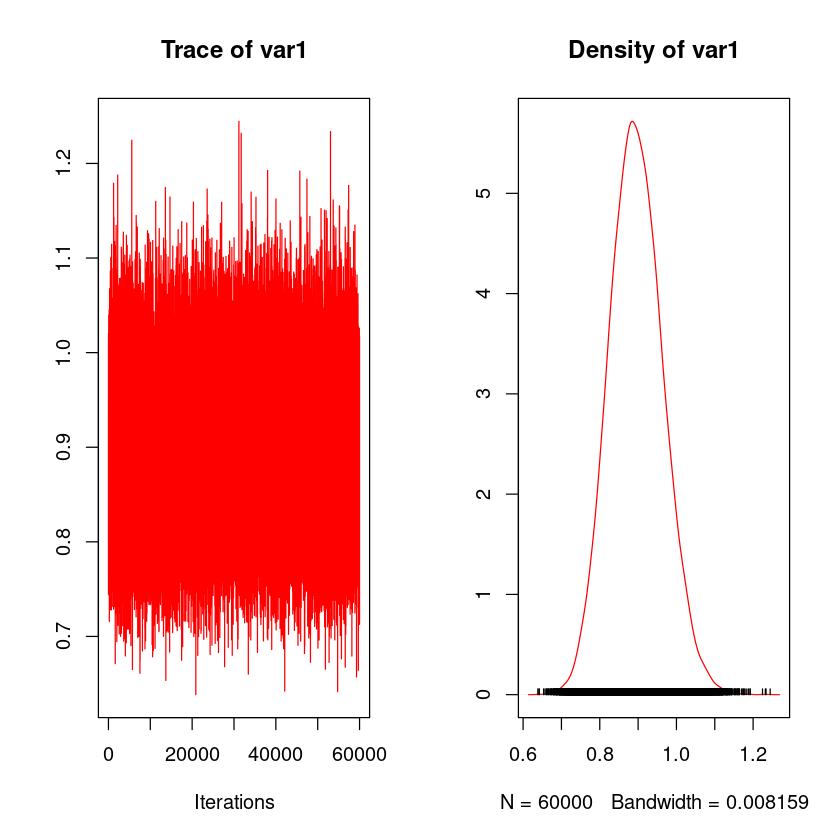

In [74]:
plot(pfizer.mcmc[,'diff_rate'],col='navy')
plot(pfizer.mcmc[,'Vaccine'],col='firebrick')
plot(pfizer.mcmc[,'Placebo'],col='forestgreen')
plot(pfizer.mcmc[,'Vaccine_perc'],col='gold')
plot(pfizer.mcmc[,'Placebo_perc'],col='red')